In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
import datetime
import empyrical
%matplotlib inline

In [2]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
start_date, today = '2016-06-01', datetime.datetime.today()

In [5]:
data = w.wsd('000985.CSI,000012.SH', 'close', start_date, today)

In [6]:
bas_df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=['st', 'bd'])

In [7]:
bas_st_ret = bas_df['st'].pct_change()
bas_bd_ret = bas_df['bd'].pct_change()

# 全市场基金组合

In [11]:
df = pd.read_excel(u'../data/蚂蚁组合基金权重.xlsx', sheet_name=u'1090组合', index_col=0)
df_js = pd.read_excel(u'../data/天天组合基金权重.xlsx', sheet_name=u'1090组合', index_col=0)

In [12]:
df

,基金代码,基金名称,模型权重
基金序号,,,
1,160716.OF,嘉实基本面50指数(LOF)A,0.0288
2,110022.OF,易方达消费行业,0.0192
3,070021.OF,嘉实主题新动力,0.0192
4,519772.OF,交银新生活力,0.0128
5,004544.OF,嘉实稳华纯债,0.5460
6,070009.OF,嘉实超短债,0.3640
7,000216.OF,华安易富黄金ETF联接A,0.0100


In [13]:
df_js

,基金代码,基金名称,基金权重
基金序号,,,
1,160716.OF,嘉实基本面50指数(LOF)A,0.0288
2,070019.OF,嘉实价值优势,0.0192
3,070011.OF,嘉实策略增长,0.0128
4,070021.OF,嘉实主题新动力,0.0192
5,004544.OF,嘉实稳华纯债,0.2730
6,070037.OF,嘉实纯债A,0.2730
7,070009.OF,嘉实超短债,0.3640
8,160719.OF,嘉实黄金(QDII-FOF-LOF),0.0100


In [14]:
codes = df[u'基金代码'].tolist()

In [15]:
data = w.wsd(codes, 'nav_adj', start_date, today)

In [16]:
nav_all = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=codes)
nav_all.index = pd.to_datetime(nav_all.index)

In [17]:
codes = df_js[u'基金代码'].tolist()

In [18]:
data = w.wsd(codes, 'nav_adj', start_date, today)

In [19]:
nav_js = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=codes)
nav_js.index = pd.to_datetime(nav_js.index)

In [20]:
ret_all = nav_all.pct_change()

In [21]:
ret_all.head()

,160716.OF,110022.OF,070021.OF,519772.OF,004544.OF,070009.OF,000216.OF
2016-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-02,-0.001334,0.004815,0.007545,NaN,NaN,0.000000,-0.001245
2016-06-03,0.005631,0.021565,0.002723,NaN,NaN,0.000000,-0.002181
2016-06-06,-0.002752,0.003909,0.006789,NaN,NaN,0.000291,0.019673
2016-06-07,-0.000190,0.003115,-0.000674,NaN,NaN,0.000000,0.001531


In [22]:
ret_js = nav_js.pct_change()

In [23]:
ret_js.head()

,160716.OF,070019.OF,070011.OF,070021.OF,004544.OF,070037.OF,070009.OF,160719.OF
2016-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-02,-0.001334,0.004051,0.007564,0.007545,NaN,0.000000,0.000000,-0.004386
2016-06-03,0.005631,0.009415,0.021021,0.002723,NaN,0.000000,0.000000,0.024963
2016-06-06,-0.002752,0.007995,0.004412,0.006789,NaN,0.000859,0.000291,-0.001433
2016-06-07,-0.000190,-0.001983,0.000732,-0.000674,NaN,0.000000,0.000000,0.000000


In [24]:
def back_test(ret, st_weight, bd_weight, gd_weight, n_st, n_bd, n_gd):
    '''
    ret: 收益率矩阵
    st_weight: 股票比例
    bd_weight: 债券比列
    gd_weight: 黄金比例
    n_st: 股票基金数量
    n_bd: 债券基金数量
    n_gd: 黄金基金数量
    '''
    
    def rebalance(ret_date, init_weights):
        wb = (1 - ret_date.isna().astype(int)) * init_weights
        wb[:n_st] = wb[:n_st] / wb[:n_st].sum() * st_weight # 考虑股票基金当前没有成立
        wb[n_st:n_st+n_bd] = wb[n_st:n_st+n_bd] / wb[n_st:n_st+n_bd].sum() * bd_weight # 考虑债券及基金当前没有成立
        wb = wb / wb.sum()
        return wb
    
    assert(st_weight + bd_weight + gd_weight == 1)
    assert(n_st + n_bd + n_gd == ret.shape[1])
    weight = pd.DataFrame(columns=ret.columns, index=ret.index)
    init_weights = np.array([st_weight / n_st] * n_st + [bd_weight / n_bd] * n_bd + [gd_weight]) # 股债比例
    rebalance_dates = ret.resample('M').last().index
    rb_date_index = 0
    wb = rebalance(ret.iloc[1], init_weights)
    for date in ret.index[1:]: # 第一天全为NAN，所以从[1:]开始
        weight.loc[date] = wb
        wb *= (1 + ret.loc[date].fillna(0)) # 权重随净值增长
        wb /= wb.sum() # 权重调整
        if date > rebalance_dates[rb_date_index]: # 再平衡
#             print(date, "rebalance")
            if rb_date_index < rebalance_dates.size:
                rb_date_index += 1
            wb = rebalance(ret.loc[date], init_weights)
    return weight

# 10/90组合

# 全市场基金回测

In [25]:
weight_all = back_test(ret_all, 0.1, 0.89, 0.01, 4, 2, 1)

In [26]:
pf_ret_all = (weight_all * ret_all).sum(axis=1)

# 嘉实基金组合回测

In [27]:
weight_js = back_test(ret_js, 0.1, 0.89, 0.01, 4, 3, 1)

In [28]:
pf_ret_js = (weight_js * ret_js).sum(axis=1)

In [29]:
pf_df = pd.DataFrame()

In [30]:
pf_df[u'全市场10/90组合'] = (1 + pf_ret_all).cumprod()
pf_df[u'嘉实10/90组合'] = (1 + pf_ret_js).cumprod()

In [31]:
year_ret_df = pd.DataFrame()
year_ret_df[u'全市场10/90组合'] = pf_ret_all.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df[u'嘉实10/90组合'] = pf_ret_js.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))

In [35]:
bas_ret = bas_st_ret * 0.1 + bas_bd_ret * 0.9

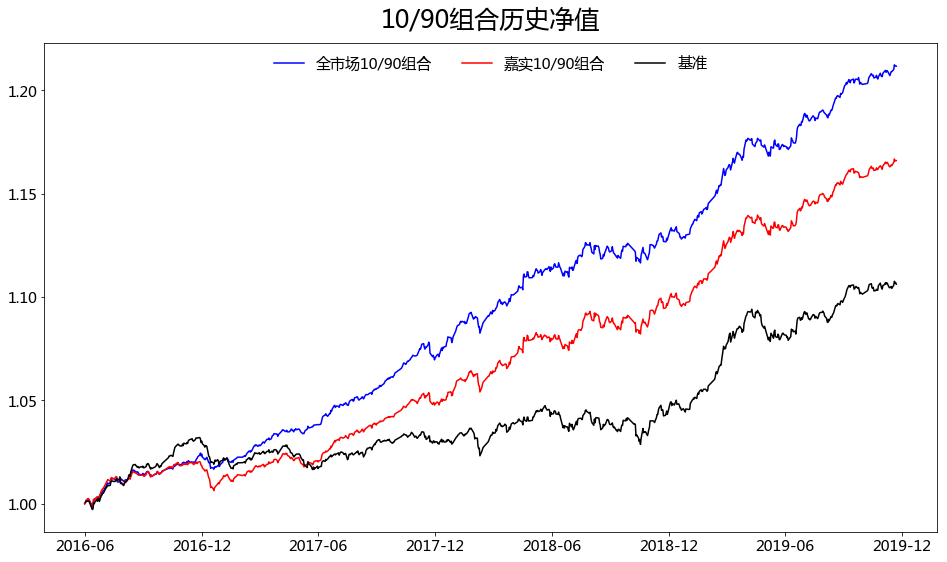

In [36]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + pf_ret_all).cumprod(), color='blue', label=u'全市场10/90组合')
lns2 = ax.plot((1 + pf_ret_js).cumprod(), color='red', label=u'嘉实10/90组合')
lns3 = ax.plot((1 + bas_ret).cumprod(), color='black', label=u'基准')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

_ = ax.set_title(u'10/90组合历史净值', fontsize=25, y=1.02)

In [37]:
metric(pf_ret_all)

Annual return: 5.87%
Sharpe ratio: 2.71
Annual volatility: 1.73%
Max drawdown: -0.93%


In [38]:
metric(pf_ret_js)

Annual return: 4.67%
Sharpe ratio: 2.03
Annual volatility: 1.75%
Max drawdown: -1.37%


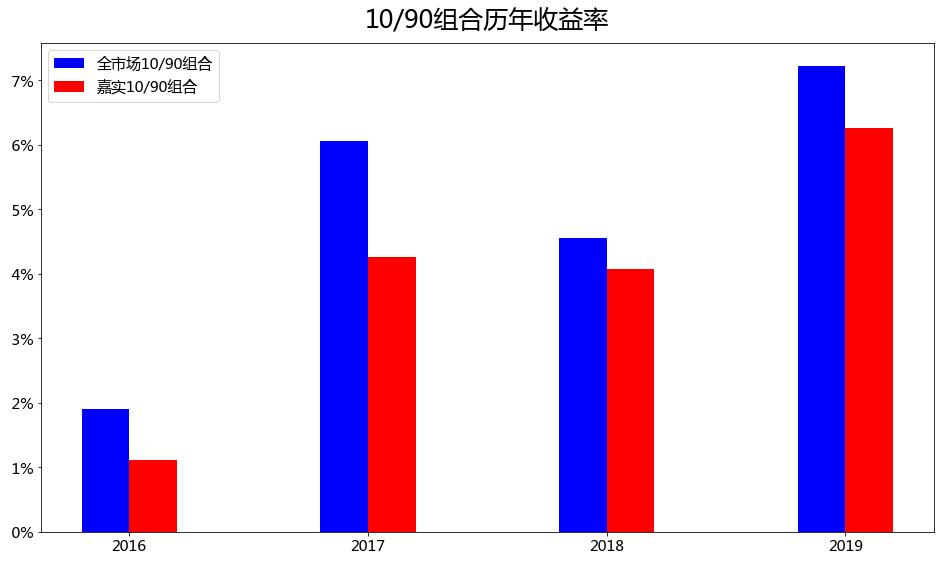

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(year_ret_df.shape[0])

ax.bar(x - 0.1, year_ret_df[u'全市场10/90组合'], width=0.2, align='center', label=u'全市场10/90组合', color='blue')
ax.bar(x + 0.1, year_ret_df[u'嘉实10/90组合'], width=0.2, align='center', label=u'嘉实10/90组合', color='red')

ax.set_xticks(x)
ax.set_xticklabels(year_ret_df.index.year)

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'10/90组合历年收益率', fontsize=25, y=1.02)

# 20/80组合

In [40]:
weight_all = back_test(ret_all, 0.2, 0.78, 0.02, 4, 2, 1)

In [41]:
pf_ret_all = (weight_all * ret_all).sum(axis=1)

In [42]:
weight_js = back_test(ret_js, 0.2, 0.78, 0.02, 4, 3, 1)

In [43]:
pf_ret_js = (weight_js * ret_js).sum(axis=1)

In [44]:
pf_df[u'全市场20/80组合'] = (1 + pf_ret_all).cumprod()
pf_df[u'嘉实20/80组合'] = (1 + pf_ret_js).cumprod()

In [45]:
year_ret_df[u'全市场20/80组合'] = pf_ret_all.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df[u'嘉实20/80组合'] = pf_ret_js.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))

In [46]:
bas_ret = bas_st_ret * 0.2 + bas_bd_ret * 0.8

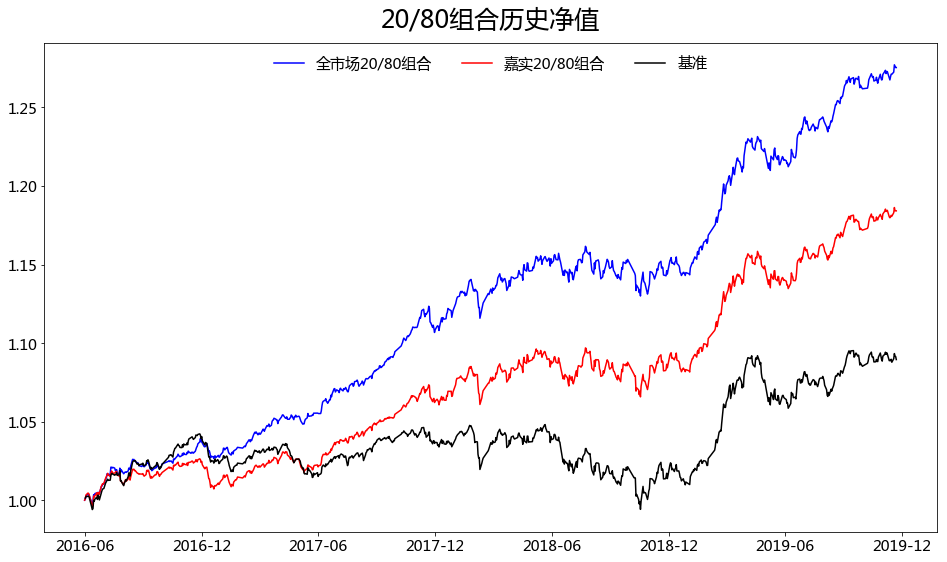

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + pf_ret_all).cumprod(), color='blue', label=u'全市场20/80组合')
lns2 = ax.plot((1 + pf_ret_js).cumprod(), color='red', label=u'嘉实20/80组合')
lns3 = ax.plot((1 + bas_ret).cumprod(), color='black', label=u'基准')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

_ = ax.set_title(u'20/80组合历史净值', fontsize=25, y=1.02)

In [48]:
metric(pf_ret_all)

Annual return: 7.50%
Sharpe ratio: 1.85
Annual volatility: 3.37%
Max drawdown: -2.72%


In [49]:
metric(pf_ret_js)

Annual return: 5.15%
Sharpe ratio: 1.20
Annual volatility: 3.39%
Max drawdown: -2.84%


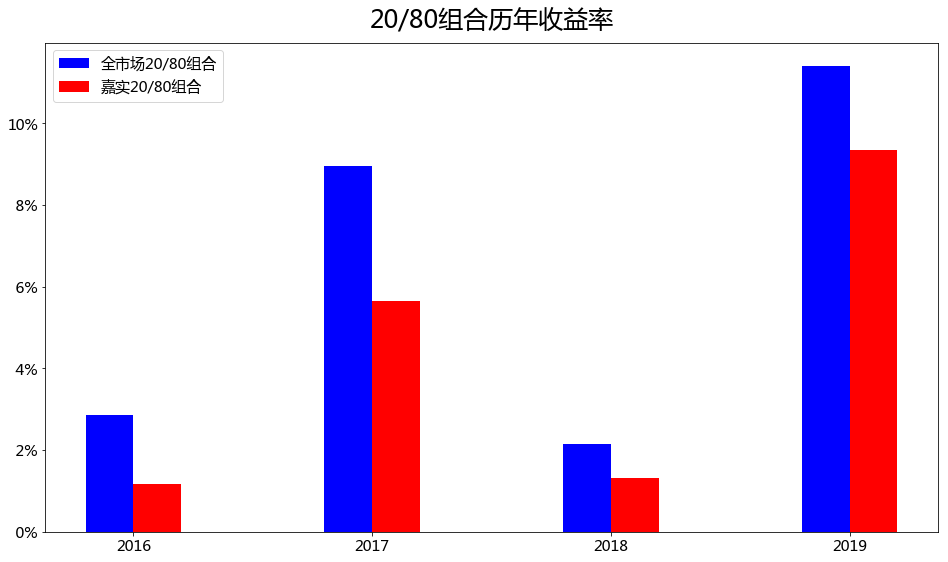

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(year_ret_df.shape[0])

ax.bar(x - 0.1, year_ret_df[u'全市场20/80组合'], width=0.2, align='center', label=u'全市场20/80组合', color='blue')
ax.bar(x + 0.1, year_ret_df[u'嘉实20/80组合'], width=0.2, align='center', label=u'嘉实20/80组合', color='red')

ax.set_xticks(x)
ax.set_xticklabels(year_ret_df.index.year)

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'20/80组合历年收益率', fontsize=25, y=1.02)

# 40/60组合

In [51]:
weight_all = back_test(ret_all, 0.4, 0.56, 0.04, 4, 2, 1)

In [52]:
pf_ret_all = (weight_all * ret_all).sum(axis=1)

In [53]:
weight_js = back_test(ret_js, 0.4, 0.56, 0.04, 4, 3, 1)

In [54]:
pf_ret_js = (weight_js * ret_js).sum(axis=1)

In [55]:
pf_df[u'全市场40/60组合'] = (1 + pf_ret_all).cumprod()
pf_df[u'嘉实40/60组合'] = (1 + pf_ret_js).cumprod()

In [56]:
year_ret_df[u'全市场40/60组合'] = pf_ret_all.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df[u'嘉实40/60组合'] = pf_ret_js.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))

In [57]:
bas_ret = bas_st_ret * 0.4 + bas_bd_ret * 0.6

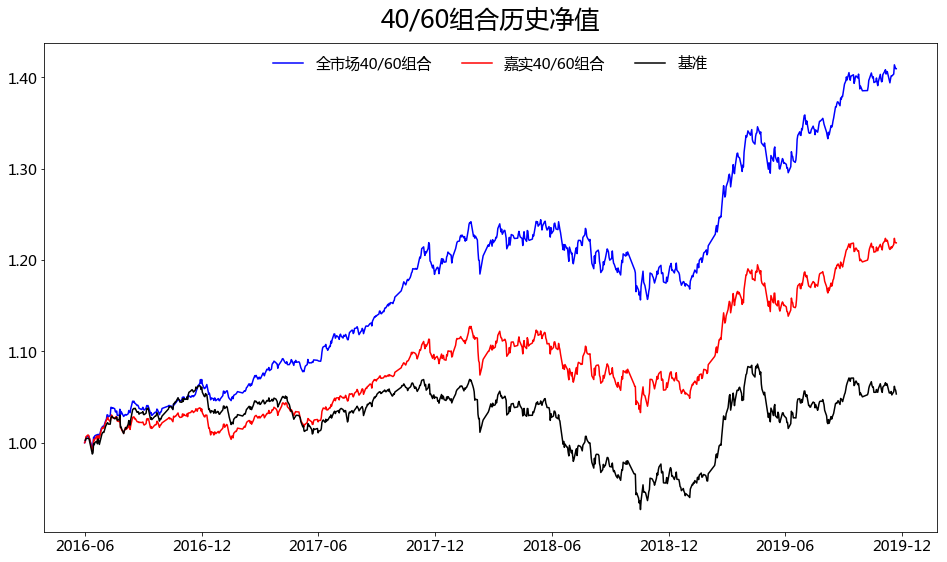

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + pf_ret_all).cumprod(), color='blue', label=u'全市场40/60组合')
lns2 = ax.plot((1 + pf_ret_js).cumprod(), color='red', label=u'嘉实40/60组合')
lns3 = ax.plot((1 + bas_ret).cumprod(), color='black', label=u'基准')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

_ = ax.set_title(u'40/60组合历史净值', fontsize=25, y=1.02)

In [59]:
metric(pf_ret_all)

Annual return: 10.74%
Sharpe ratio: 1.40
Annual volatility: 6.71%
Max drawdown: -7.06%


In [60]:
metric(pf_ret_js)

Annual return: 6.06%
Sharpe ratio: 0.75
Annual volatility: 6.74%
Max drawdown: -8.38%


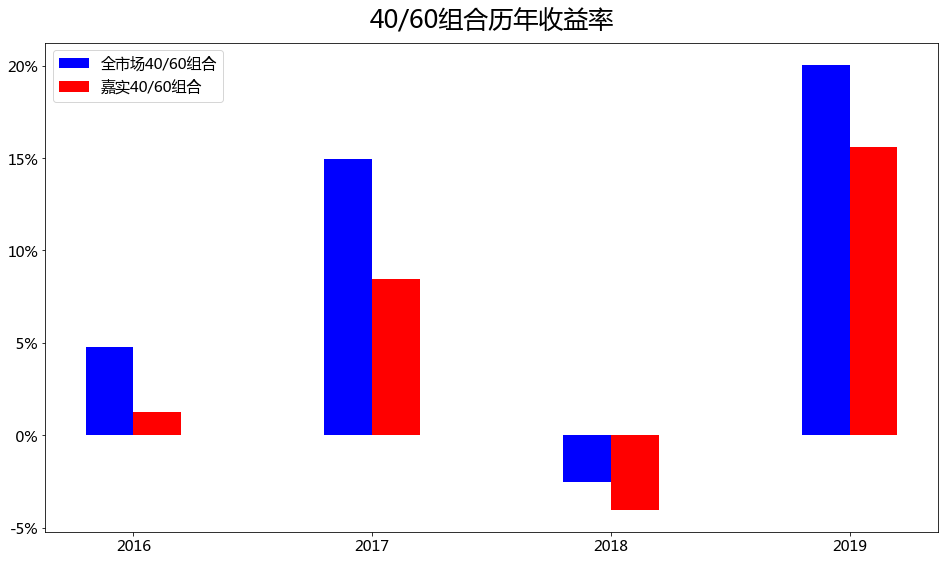

In [61]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(year_ret_df.shape[0])

ax.bar(x - 0.1, year_ret_df[u'全市场40/60组合'], width=0.2, align='center', label=u'全市场40/60组合', color='blue')
ax.bar(x + 0.1, year_ret_df[u'嘉实40/60组合'], width=0.2, align='center', label=u'嘉实40/60组合', color='red')

ax.set_xticks(x)
ax.set_xticklabels(year_ret_df.index.year)

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'40/60组合历年收益率', fontsize=25, y=1.02)

In [62]:
pf_df.to_excel(u'../data/组合历史净值.xlsx')